In [267]:
#  !pip install sidetable
#  !pip install tabulate

In [268]:
import pandas as pd;import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sidetable as stb

from IPython.display import HTML, display
import tabulate
import re
%matplotlib inline

## Read the data to Pandas Data Frame

In [269]:
df = pd.read_csv("https://raw.githubusercontent.com/psiva2019/CustmerChurn/master/CustumerChurnData.csv",error_bad_lines=False)
df.head()

,AccountID,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device
0,20000,1,4,3.0,6.0,Debit Card,Female,3.0,3,Super,2.0,Single,9,1.0,11,1,5,160,Mobile
1,20001,1,0,1.0,8.0,UPI,Male,3.0,4,Regular Plus,3.0,Single,7,1.0,15,0,0,121,Mobile
2,20002,1,0,1.0,30.0,Debit Card,Male,2.0,4,Regular Plus,3.0,Single,6,1.0,14,0,3,NaN,Mobile
3,20003,1,0,3.0,15.0,Debit Card,Male,2.0,4,Super,5.0,Single,8,0.0,23,0,3,134,Mobile
4,20004,1,0,1.0,12.0,Credit Card,Male,2.0,3,Regular Plus,5.0,Single,3,0.0,11,1,3,130,Mobile


## Data Report

In [270]:
#Shape of the Data
print('****Shape of the hotel data****')
print('********************************')
print('No of rows\t:\t{}\nNo of columns\t:\t{}'.format(df.shape[0],df.shape[1]))

****Shape of the hotel data****
********************************
No of rows	:	11260
No of columns	:	19


In [271]:
print('****Show infomation of the train data****')
print('***********************************')
df.info()

****Show infomation of the train data****
***********************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11260 entries, 0 to 11259
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AccountID                11260 non-null  int64  
 1   Churn                    11260 non-null  int64  
 2   Tenure                   11158 non-null  object 
 3   City_Tier                11148 non-null  float64
 4   CC_Contacted_LY          11158 non-null  float64
 5   Payment                  11151 non-null  object 
 6   Gender                   11152 non-null  object 
 7   Service_Score            11162 non-null  float64
 8   Account_user_count       11148 non-null  object 
 9   account_segment          11163 non-null  object 
 10  CC_Agent_Score           11144 non-null  float64
 11  Marital_Status           11048 non-null  object 
 12  rev_per_month            11158 non-null  object 
 13

In [272]:
#Check for duplicate values
print('****Duplicates data in the train dataset without EmployeeID Column****')
print('**********************************************************************')

dups = df.loc[:, ~df.columns. isin(['EmployeeID'])].duplicated().sum()
if dups ==0:
    print('There is no duplicate values in the data.') 
else:
    print('There are {} duplicates in the data which is {}% of total data'.format(dups,round((dups/df.shape[0])*100,2)))

****Duplicates data in the train dataset without EmployeeID Column****
**********************************************************************
There is no duplicate values in the data.


In [273]:
#Check for missing value
print('****Missing Values in the Dataset****')
print('*************************************')
msv = df.isnull().sum()[df.isnull().sum()>0]
if msv.empty:
    print('There is no missing values in the data.') 
else:
    for i in range(msv.count()):
        print('{} Missing values in {} which is {}% of total data ({})'.format(msv[i],msv.index[i],round(((msv[i]/df.shape[0])*100),2),df[msv.index[i]].dtype))

****Missing Values in the Dataset****
*************************************
102 Missing values in Tenure which is 0.91% of total data (object)
112 Missing values in City_Tier which is 0.99% of total data (float64)
102 Missing values in CC_Contacted_LY which is 0.91% of total data (float64)
109 Missing values in Payment which is 0.97% of total data (object)
108 Missing values in Gender which is 0.96% of total data (object)
98 Missing values in Service_Score which is 0.87% of total data (float64)
112 Missing values in Account_user_count which is 0.99% of total data (object)
97 Missing values in account_segment which is 0.86% of total data (object)
116 Missing values in CC_Agent_Score which is 1.03% of total data (float64)
212 Missing values in Marital_Status which is 1.88% of total data (object)
102 Missing values in rev_per_month which is 0.91% of total data (object)
357 Missing values in Complain_ly which is 3.17% of total data (float64)
357 Missing values in Day_Since_CC_connect which

In [274]:
def display_dataframe(df,dtypeval):
    numeric_col_mask = df.dtypes.apply(lambda d: issubclass(np.dtype(d).type, dtypeval))

    # Dict used to center the table headers
    d = dict(selector="th",
        props=[('text-align', 'left')])

    # Style
    display(df.style.set_properties(subset=df.columns[numeric_col_mask], 
                            **{'width':'15em', 'height':'3em','text-align':'left','border-color':'White','border-width':'thin'})\
            .set_properties(subset=df.columns[~numeric_col_mask], 
                            **{'width':'15em', 'text-align':'left','border-color':'White','border-width':'thin'})\
            .format(lambda x: '{:,.0f}'.format(x) if x > 1e3 else '{:,.2f}'.format(x), # format the numeric values
                    subset=pd.IndexSlice[:,df.columns[numeric_col_mask]])\
            .hide_index()\

#            .highlight_max('color: green')\
            .set_table_styles([d])) # center the header

In [275]:
def check_sp(Vars,fixit,data_df):
  tot = len(Vars['num'])+len(Vars['chars'])

  s = [[None for j in range(3)] for i in range(tot)]
  i=0
  for type_var in Vars:
    for var in Vars[type_var]:
      livars=[]
      li=data_df[var].unique()
      if(type_var=='num'):
        livars = list(filter(lambda x: (str(x).replace('.','').isdigit()!=True and str(x)!='nan'),li))
        if(fixit==True):
          for k in livars:
            data_df[var].replace(k,np.nan,inplace=True)
      else:
        li1 = list(filter(lambda x: (str(x).replace(' ','').isalpha()!=True and str(x)!='nan'),li))
        pattern = r'\W'
        
        li2 = []
        for j in li1:
          find = re.compile(pattern)
          ff = find.findall(j.replace(' ',''))[0]
          li2.append(ff)
        livars = list(set(li2))
      s[i][0] = var
      s[i][1] = livars if(livars!=[]) else 'No Special Chars'
      s[i][2] = 'Numeric' if(type_var=='num') else 'Charecter'
      i=i+1
  rdf = pd.DataFrame(data=s,columns=['Column','SpecialChars','DataType'])
  return(rdf)

In [276]:
Vars = {'num': ['Tenure','Account_user_count','rev_per_month','coupon_used_for_payment','Day_Since_CC_connect','cashback'],'chars':['account_segment','Payment','Gender','Marital_Status','Login_device'] }

spdf = check_sp(Vars,True,df)
display_dataframe(spdf,str)

Column,SpecialChars,DataType
Tenure,['#'],Numeric
Account_user_count,['@'],Numeric
rev_per_month,['+'],Numeric
coupon_used_for_payment,"['#', '$', '*']",Numeric
Day_Since_CC_connect,['$'],Numeric
cashback,['$'],Numeric
account_segment,['+'],Charecter
Payment,No Special Chars,Charecter
Gender,No Special Chars,Charecter
Marital_Status,No Special Chars,Charecter


In [277]:
df['account_segment'].value_counts()

Super           4062
Regular Plus    3862
HNI             1639
Super Plus       771
Regular          520
Regular +        262
Super +           47
Name: account_segment, dtype: int64

In [278]:
df['Login_device'].value_counts()

Mobile      7482
Computer    3018
&&&&         539
Name: Login_device, dtype: int64

In [279]:
df['account_segment'].replace('Super +','Super Plus',inplace=True)
df['account_segment'].replace('Regular +','Regular Plus',inplace=True)
df['Login_device'].replace('&&&&','Mobile',inplace=True)

df['Gender'].replace('Male','M',inplace=True)
df['Gender'].replace('Female','F',inplace=True)

In [280]:
spdf = check_sp(Vars,False,df)
display_dataframe(spdf,str)

Column,SpecialChars,DataType
Tenure,No Special Chars,Numeric
Account_user_count,No Special Chars,Numeric
rev_per_month,No Special Chars,Numeric
coupon_used_for_payment,No Special Chars,Numeric
Day_Since_CC_connect,No Special Chars,Numeric
cashback,No Special Chars,Numeric
account_segment,No Special Chars,Charecter
Payment,No Special Chars,Charecter
Gender,No Special Chars,Charecter
Marital_Status,No Special Chars,Charecter


In [281]:
Vars = {'num': ['Tenure','rev_per_month','cashback','CC_Contacted_LY'],'chars':['Complain_ly','CC_Agent_Score','Service_Score','City_Tier','Account_user_count','coupon_used_for_payment','Day_Since_CC_connect','account_segment','Payment','Gender','Marital_Status','Login_device'] }

for vars in Vars['chars']:
  df[vars].fillna(df[vars].mode()[0],inplace=True)

for vars in Vars['num']:
  df[vars].fillna(df[vars].median(),inplace=True)
  if(df[vars].dtype=='object'):
    df[vars] = df[vars].astype('int64')

In [282]:
#Check for missing value
print('****Missing Values in the Dataset****')
print('*************************************')
msv = df.isnull().sum()[df.isnull().sum()>0]
if msv.empty:
    print('There is no missing values in the data.') 
else:
    for i in range(msv.count()):
        print('{} Missing values in {} which is {}% of total data ({})'.format(msv[i],msv.index[i],round(((msv[i]/df.shape[0])*100),2),df[msv.index[i]].dtype))

****Missing Values in the Dataset****
*************************************
There is no missing values in the data.


In [283]:
def unq_count_new(df,var,top_val,tit,dpn):
    #var='meal'

    if(top_val == 0):
        perclass = pd.DataFrame(df[var].value_counts(normalize=True,dropna=dpn))
        tardisval = pd.DataFrame(df[var].value_counts(dropna=dpn))
    else:
        perclass = pd.DataFrame(df[var].value_counts(normalize=True,dropna=dpn)[df[var].value_counts(dropna=dpn)>top_val])
        tardisval = pd.DataFrame(df[var].value_counts(dropna=dpn)[df[var].value_counts(dropna=dpn)>top_val])
        
    disdf = pd.concat([tardisval,round(perclass*100,3)],axis=1)
    disdf.reset_index()
    disdf.columns=['Count','Percent']

    str1 = f'**** Unique value distribution of {tit.title()} ******'

    width = len(str1)
    filler = '*'

    print(str1)
    print(f'{"*" :{filler}>{width}}\n')

    print(tabulate.tabulate(disdf, tablefmt='fancy_grid',headers=[tit.title(),'Count','Percent']))
    #return (disdf)

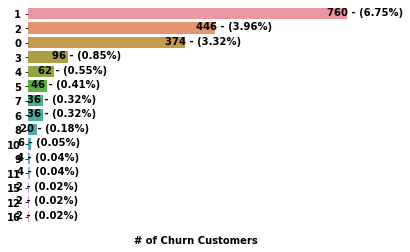

In [285]:
dff=df
typevar='char'
var='coupon_used_for_payment'
tar='Churn'
tit='coupon_used_for_payment'

textlab='# of Customers'
textlab_tar='# of Churn Customers'


result = dff.groupby([var])[tar].aggregate(np.sum).reset_index().sort_values(tar,ascending = False)
#print(result[result[tar]>0])
result = result[result[tar]>0]
b = sns.barplot(data=result, y=var,x=tar,orient='h',order=result[var])


b.set_frame_on(False)

b.set_ylabel('')
#b.set_ylabel(var,weight='bold')
b.set_xlabel(textlab_tar,weight='bold')

b.set_xticklabels([])
b.tick_params(bottom=False)
b.set_yticklabels(list(result[var].value_counts().index),weight='bold')
#b.set_yticklabels([])
maxwidth = dff[var].value_counts().max()
for p in b.patches:
    width = np.nan_to_num(p.get_width()) 
    wdplace = width
    per = (width/dff.shape[0])*100
    wdplace = wdplace + maxwidth * 1/100
    
    b.text(wdplace,
        p.get_y()+.5,
        '{} - ({:1.2f}%)'.format(round(width),(width/dff.shape[0])*100),
        ha="center",weight='bold') 

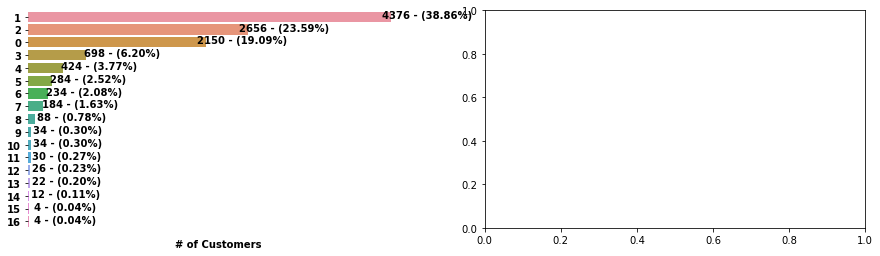

In [286]:
dff=df
typevar='char'
var='coupon_used_for_payment'
tar='Churn'
tit='coupon_used_for_payment'

textlab='# of Customers'
textlab_tar='# of Churn Customers'

fig, axis=plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(15,4)

a = sns.countplot(data=dff, y=var,ax=axis[0],order=dff[var].value_counts().index)

a.set_frame_on(False)

#a.set_ylabel(var,weight='bold')
a.set_ylabel('')
a.set_xlabel(textlab,weight='bold')


a.set_xticklabels([])
a.tick_params(bottom=False)
a.set_yticklabels(list(dff[var].value_counts().index),weight='bold')

maxwidth = dff[var].value_counts().max()

for p in a.patches:
    width = np.nan_to_num(p.get_width()) 
    wdplace = width
    per = (width/dff.shape[0])*100
    #print(width)
    wdplace = wdplace + maxwidth * 10/100
    # if(per < 1):
    #     wdplace = wdplace + maxwidth * 10/100
    # else:
    #     wdplace = wdplace - maxwidth * 10/100
    
    a.text(wdplace,
        p.get_y()+.5,
        '{} - ({:1.2f}%)'.format(round(width),per),
        ha="center",weight='bold') 

### Univarient Analsyis

In [287]:
def display_unq(dff,var,tar,bins,typevar,tit,textlab,textlab_tar):
  if(typevar=='num'):
    fig, axis=plt.subplots(nrows=1,ncols=3)
    fig.set_size_inches(20,3)

    str1 = f'**** {tit.title()} ****'

    width = len(str1)
    filler = '*'

    print(str1)
    print(f'{"*" :{filler}>{width}}\n')

    dff_r = pd.DataFrame(round(dff[var].describe(),2)).T
    display(tabulate.tabulate(dff_r, tablefmt='html',headers=dff_r.columns))
    
    str2 = f'\n**** Visuallations of Feature {tit.title()} ****'

    width = len(str2)
    filler = '*'

    print(str2)
    print(f'{"*" :{filler}>{width}}\n')

    a= sns.histplot(dff[var],ax=axis[0],bins=bins);
    b= sns.boxplot(dff[var],ax=axis[1]);
    c= sns.kdeplot(dff[var],ax=axis[2],hue=df[tar])

    a.set_xlabel('')
    b.set_xlabel('')
    c.set_xlabel('')
    a.set_ylabel('')
    c.set_ylabel('')

    a.set_frame_on(False)
    b.set_frame_on(False)
    c.set_frame_on(False)

  else:
    fig, axis=plt.subplots(nrows=1,ncols=2)
    fig.set_size_inches(15,4)

    #unq_count_new(dff,var,0,tit,True)

    str2 = f'\n**** Visuallations of Feature {tit.title()} ****'

    width = len(str2)
    filler = '*'

    print(str2)
    print(f'{"*" :{filler}>{width}}\n')

    a = sns.countplot(data=dff, y=var,ax=axis[0],order=dff[var].value_counts().index)

    a.set_frame_on(False)

    #a.set_ylabel(var,weight='bold')
    a.set_ylabel('')
    a.set_xlabel(textlab,weight='bold')


    a.set_xticklabels([])
    a.tick_params(bottom=False)
    a.set_yticklabels(list(dff[var].value_counts().index),weight='bold')

    for p in a.patches:
        width = np.nan_to_num(p.get_width()) 
        per = (width/dff.shape[0])*100
        #print(width,p.get_y(),per)

        if(per < 1):
            width = width + 750
        else:
            width = width + 220
        
        a.text(width,
            p.get_y()+.5,
            '{} - ({:1.2f}%)'.format(width,(width/dff.shape[0])*100),
            ha="center",weight='bold') 
    
    result = dff.groupby([var])[tar].aggregate(np.sum).reset_index().sort_values(tar,ascending = False)
    result = result[result[tar]>0]
    b = sns.barplot(data=result, y=var,x=tar,orient='h',order=result[var],ax=axis[1])

    b.set_frame_on(False)

    b.set_ylabel('')
    #b.set_ylabel(var,weight='bold')
    b.set_xlabel(textlab_tar,weight='bold')

    b.set_xticklabels([])
    b.tick_params(bottom=False)
    b.set_yticklabels(list(result[var].value_counts().index),weight='bold')
    #b.set_yticklabels([])

    for p in b.patches:
        width = np.nan_to_num(p.get_width()) 
        per = (width/dff.shape[0])*100
        #print(width,p.get_y(),per)

        if(per < 1):
            width = width + 750
        else:
            width = width + 20
        
        b.text(width,
            p.get_y()+.5,
            '{} - ({:1.2f}%)'.format(width,(width/dff.shape[0])*100),
            ha="center",weight='bold') 


**** Tenure ****
****************



,count,mean,std,min,25%,50%,75%,max
Tenure,11260,10.99,12.76,0,2,9,16,99



**** Visuallations of Feature Tenure ****
******************************************



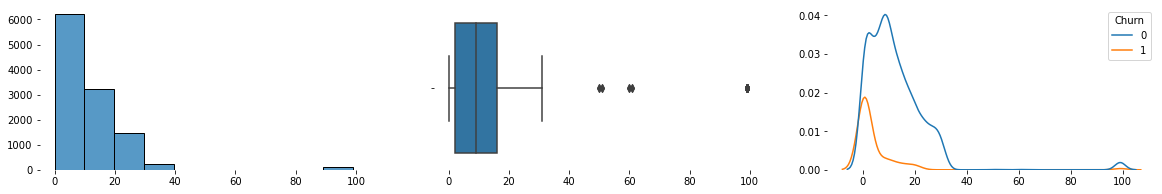

In [288]:
textlab='# of Customers'
textlab_tar='# of Churn Customers'

display_unq(df,'Tenure','Churn',10,'num','Tenure',textlab,textlab_tar)

**** Rev Per Month ****
***********************



,count,mean,std,min,25%,50%,75%,max
rev_per_month,11260,6.27,11.49,1,3,5,7,140



**** Visuallations of Feature Rev Per Month ****
*************************************************



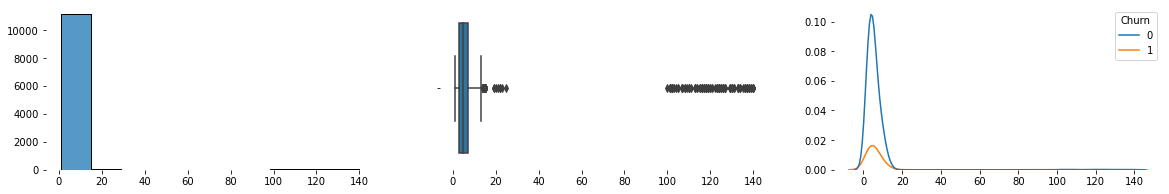

In [289]:
display_unq(df,'rev_per_month','Churn',10,'num','Rev Per Month',textlab,textlab_tar)

**** Cashback ****
******************



,count,mean,std,min,25%,50%,75%,max
cashback,11260,194.92,174.98,0,148,165,197,1997



**** Visuallations of Feature Cashback ****
********************************************



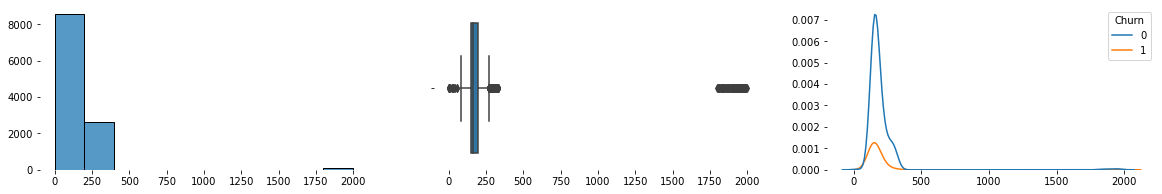

In [290]:
display_unq(df,'cashback','Churn',10,'num','Cashback',textlab,textlab_tar)

**** Cc_Contacted_Ly ****
*************************



,count,mean,std,min,25%,50%,75%,max
CC_Contacted_LY,11260,17.85,8.81,4,11,16,23,132



**** Visuallations of Feature Cc_Contacted_Ly ****
***************************************************



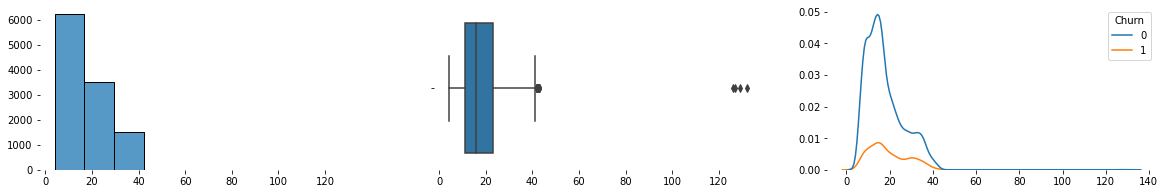

In [291]:
display_unq(df,'CC_Contacted_LY','Churn',10,'num','CC_Contacted_LY',textlab,textlab_tar)


**** Visuallations of Feature Gender ****
******************************************



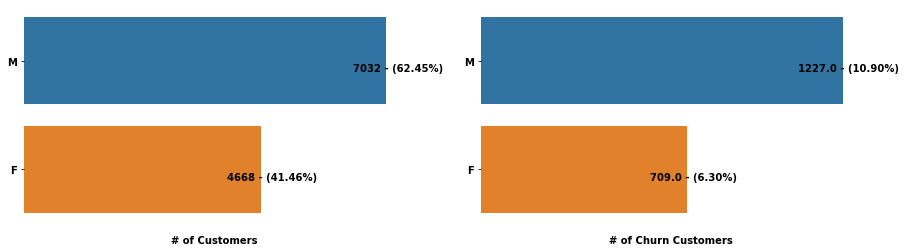

In [292]:
display_unq(df,'Gender','Churn',10,'char','Gender',textlab,textlab_tar)


**** Visuallations of Feature Cc_Agent_Score ****
**************************************************



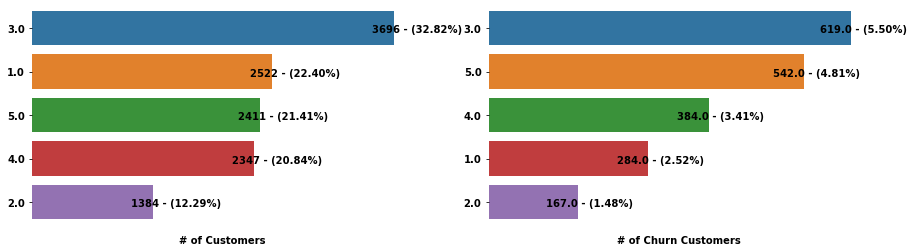

In [293]:
display_unq(df,'CC_Agent_Score','Churn',10,'char','CC_Agent_Score',textlab,textlab_tar)


**** Visuallations of Feature Service_Score ****
*************************************************



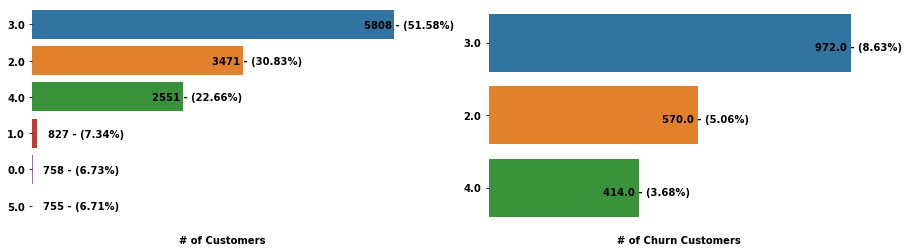

In [294]:
display_unq(df,'Service_Score','Churn',10,'char','Service_Score',textlab,textlab_tar)


**** Visuallations of Feature City_Tier ****
*********************************************



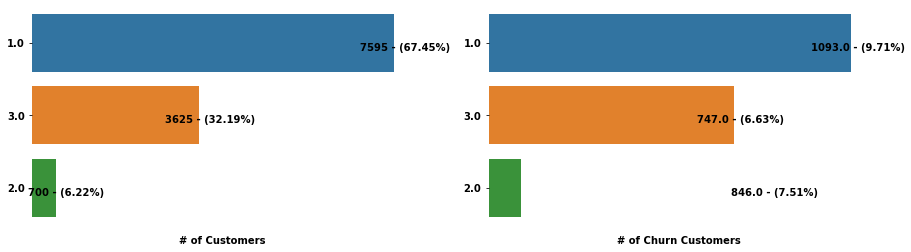

In [295]:
display_unq(df,'City_Tier','Churn',10,'char','City_Tier',textlab,textlab_tar)


**** Visuallations of Feature Account_User_Count ****
******************************************************



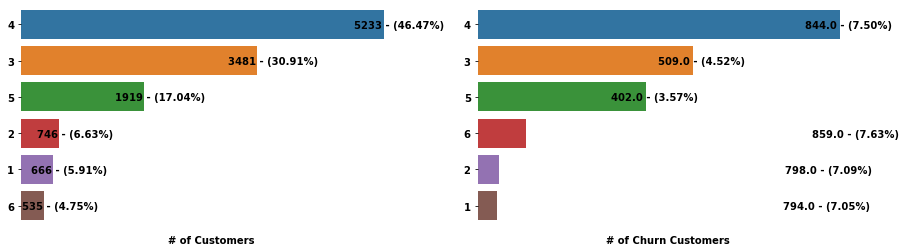

In [296]:
display_unq(df,'Account_user_count','Churn',10,'char','Account_user_count',textlab,textlab_tar)


**** Visuallations of Feature Coupon_Used_For_Payment ****
***********************************************************



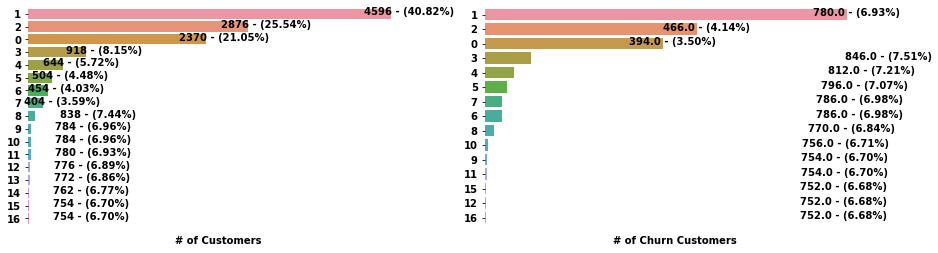

In [297]:
display_unq(df,'coupon_used_for_payment','Churn',10,'char','coupon_used_for_payment',textlab,textlab_tar)


**** Visuallations of Feature Day_Since_Cc_Connect ****
********************************************************



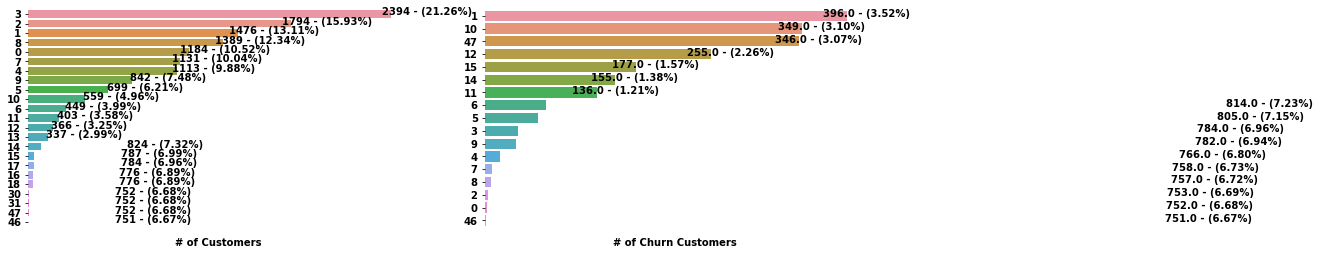

In [298]:
display_unq(df,'Day_Since_CC_connect','Churn',10,'char','Day_Since_CC_connect',textlab,textlab_tar)


**** Visuallations of Feature Account_Segment ****
***************************************************



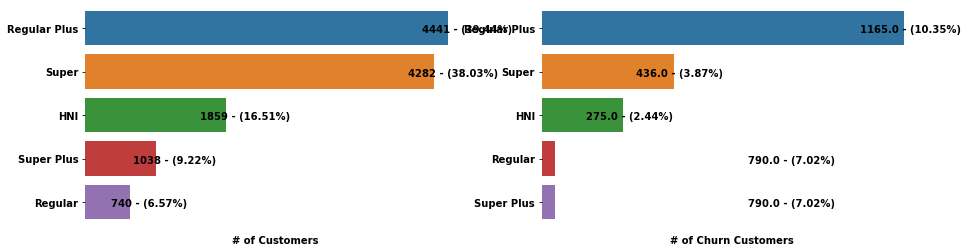

In [299]:
#'Complain_ly','CC_Agent_Score','Service_Score','City_Tier','Account_user_count','coupon_used_for_payment','Day_Since_CC_connect','account_segment','Payment','Gender','Marital_Status','Login_device'
display_unq(df,'account_segment','Churn',10,'char','account_segment',textlab,textlab_tar)


**** Visuallations of Feature Payment ****
*******************************************



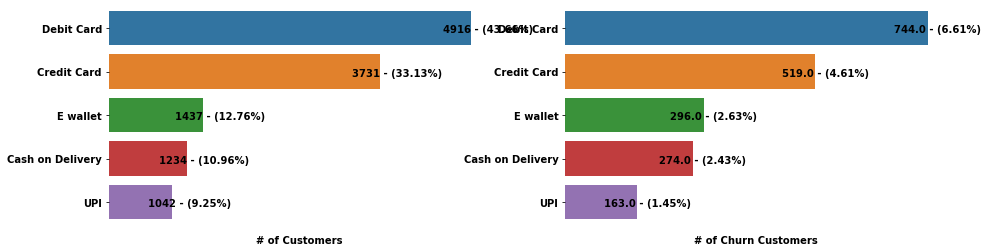

In [300]:
display_unq(df,'Payment','Churn',10,'char','Payment',textlab,textlab_tar)


**** Visuallations of Feature Marital_Status ****
**************************************************



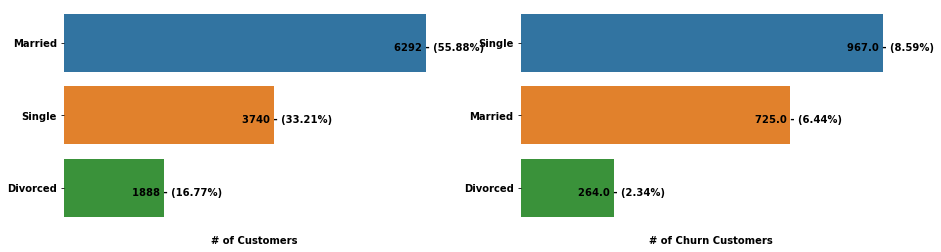

In [301]:
display_unq(df,'Marital_Status','Churn',10,'char','Marital_Status',textlab,textlab_tar)


**** Visuallations of Feature Login_Device ****
************************************************



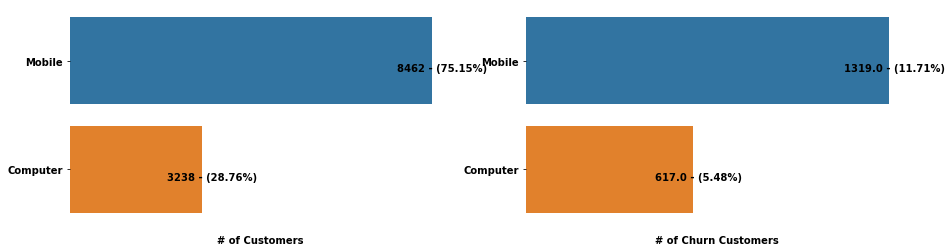

In [302]:
display_unq(df,'Login_device','Churn',10,'char','Login_device',textlab,textlab_tar)